# Explorative analysis of external data

In this notebook we will have a closer look at the external data and its distributions. As always we start with the package import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

The new data set is then loaded and it is verified that it looks correct. The original data is also loaded as it is needed for some of the analysis.

In [2]:
df_orig = pd.read_csv(os.path.abspath('../data/Processed/Cities_imputed.csv'), index_col=0)
df_geomet = pd.read_csv(os.path.abspath('../data/Processed/GeoMet_imputed.csv'), index_col=0)

print(df_geomet.shape)
df_geomet.head()

(331, 65)


,City,Country,Dist_Equator,Elevation,Dist_to_coast,Average_high_°C_Jan,Average_high_°C_Feb,Average_high_°C_Mar,Average_high_°C_Apr,Average_high_°C_May,...,Mean_monthly_sunshine_hours_Mar,Mean_monthly_sunshine_hours_Apr,Mean_monthly_sunshine_hours_May,Mean_monthly_sunshine_hours_Jun,Mean_monthly_sunshine_hours_Jul,Mean_monthly_sunshine_hours_Aug,Mean_monthly_sunshine_hours_Sep,Mean_monthly_sunshine_hours_Oct,Mean_monthly_sunshine_hours_Nov,Mean_monthly_sunshine_hours_Dec
0,Baltimore(MD),United States,4368.946697,6.0,2,5.8,7.6,12.2,18.6,24.0,...,215.0,230.7,254.5,277.3,290.1,264.4,221.8,205.5,158.5,144.5
1,Melbourne,Australia,4204.749152,25.0,4,27.0,26.9,24.6,21.1,17.6,...,226.3,186.0,142.6,123.0,136.4,167.4,186.0,226.3,225.0,263.5
2,Niamey,Niger,1503.892925,209.0,781,32.5,35.7,39.1,40.9,40.2,...,264.0,251.0,257.0,251.0,238.0,203.0,228.0,285.0,285.0,276.0
3,Hanoi,Vietnam,2338.368128,19.0,77,19.7,20.1,22.9,27.2,31.4,...,47.0,90.0,183.0,172.0,195.0,174.0,176.0,167.0,137.0,124.0
4,Urumqi,China,4828.056361,2071.0,2312,-7.4,-4.7,2.7,16.1,23.1,...,180.5,248.0,283.3,282.7,298.7,301.0,262.6,224.4,127.4,84.3


It looks correct and the shape matches what is expected.

## Geographical data

We first look at the three *geographic* variables.

### Distance to equator

The distribution of the distance to the equator could already be deducted to some degree based on the folium map in `02_Descriptive`. Below we have shown a histogram of the distribution.

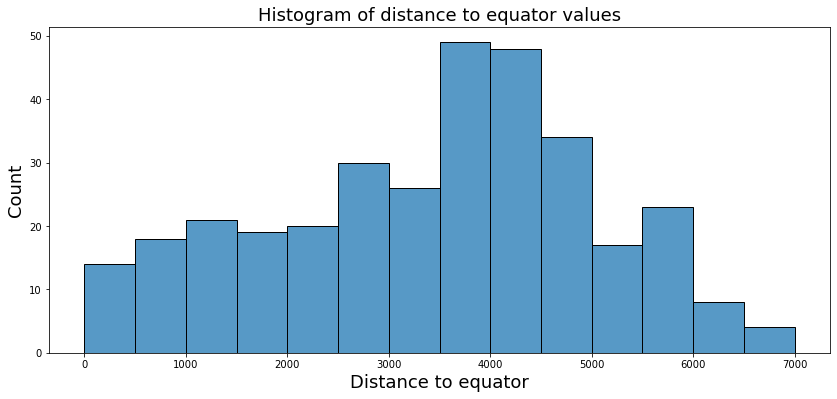

In [3]:
plt.figure(figsize=(14,6))
sns.histplot(data = df_geomet.Dist_Equator.values, 
            bins = list(range(0,int(500*(max(df_geomet.Dist_Equator.values)//500+2)),500)),
            color = "tab:blue"
            )
plt.title("Histogram of distance to equator values", fontsize = 18)
plt.xlabel("Distance to equator", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.show()

It is see that the distance to the equator overall is fairly uniform up to 6000km. There is a spike from 3500km to 5000km but it is also in this belt that most US and European cities are located so that is not surprising.

### Distance to coast and elevation

Let's also have a look at the distance to the coast and the elevation. Firstly we loo at the distance to the coast.

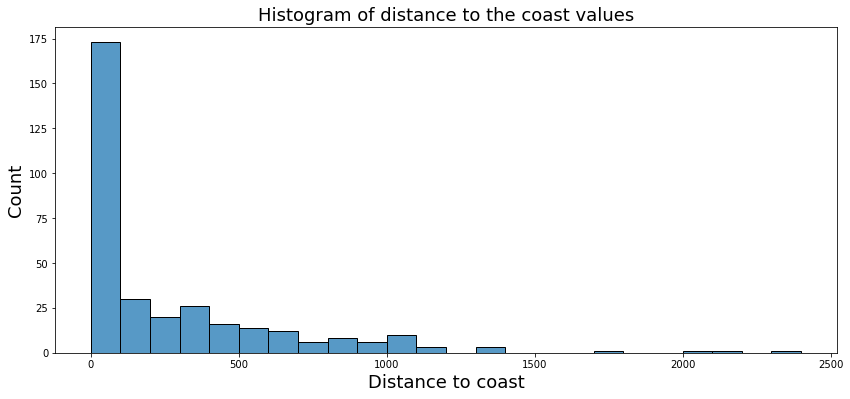

In [4]:
plt.figure(figsize=(14,6))
sns.histplot(data = df_geomet.Dist_to_coast.values, 
            bins = list(range(0,int(100*(max(df_geomet.Dist_to_coast.values)//100+2)),100)),
            color = "tab:blue"
            )
plt.title("Histogram of distance to the coast values", fontsize = 18)
plt.xlabel("Distance to coast", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.show()

Here it can be seen that around half of the cities in the dataset is located no more than 100km away from the coast. Again, this is not surprising based on the folium map from `02_descriptive`, where it clearly that most of the cities are at the coast. It is also a general historical fact that many cities lie to the coast.

Let's move on to the elevation:

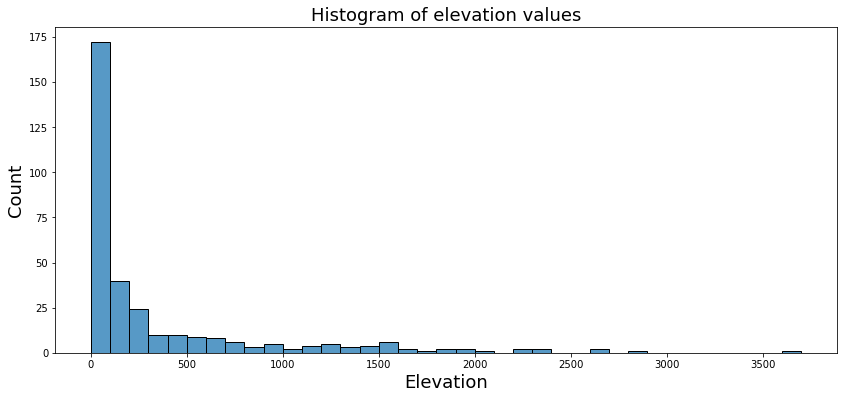

In [5]:
plt.figure(figsize=(14,6))
sns.histplot(data = df_geomet.Elevation.values, 
            bins = list(range(0,int(100*(max(df_geomet.Elevation.values)//100+2)),100)),
            color = "tab:blue"
            )
plt.title("Histogram of elevation values", fontsize = 18)
plt.xlabel("Elevation", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.show()

It is interestijng to see the elevation since no info of the elevation was available in the folium map. A similar distribution to the distance to coast is seen here where around half of the cities are located less than 100m above ground. The similarity of the two distributions leads to a suspicion that the values could be corretaed. It would not be surprising that cities close to the city also have a low elevation. Let's investigated this:

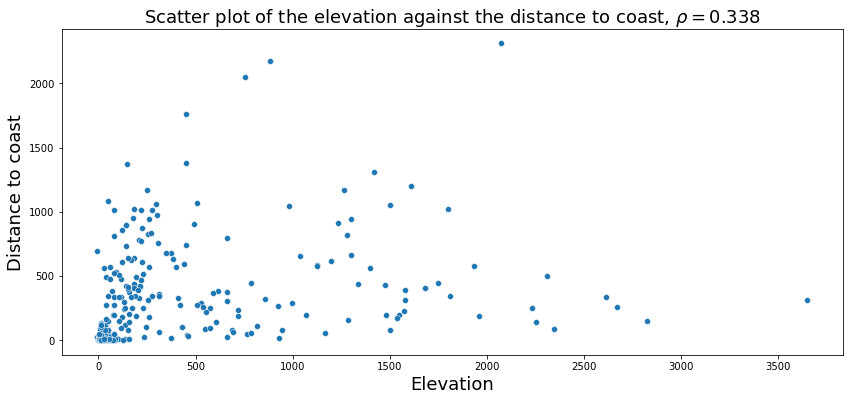

In [6]:
# Calculate correlation coefficient
corr_coef = np.corrcoef(df_geomet.Elevation.values, df_geomet.Dist_to_coast.values)[1,0]

# Plot
plt.figure(figsize=(14,6))
sns.scatterplot(x = df_geomet.Elevation.values, y = df_geomet.Dist_to_coast.values, color = "tab:blue")
plt.title(fr"Scatter plot of the elevation against the distance to coast, $\rho=${corr_coef:.3f}", fontsize = 18)
plt.xlabel("Elevation", fontsize = 18)
plt.ylabel("Distance to coast", fontsize = 18)
plt.show()

So a correlation of 0.338 is found. It is not that large but still significant. It seems like as soon as you get a bit away from the coast the elevation varies a lot more. 

## Meteorologic data

Let's move on to the investigation of the meteorologic variables. We have three types of data; temperature, precipitation and sunshine hours. We investigate them below and all as boxplots as it is numeric variables:

### Temperature

Below the boxplot of the temeprature can be seen. The plot contains both the high and low temperature

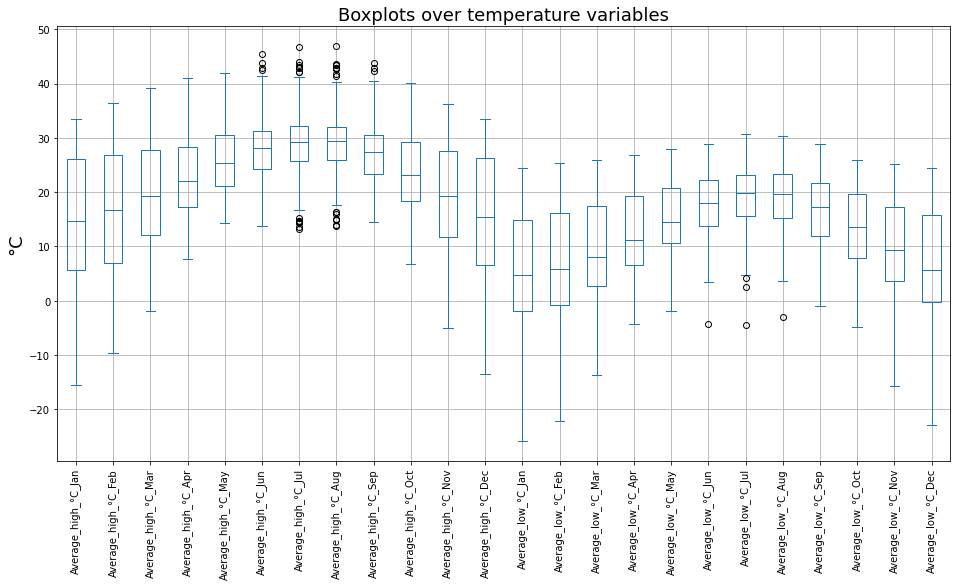

In [7]:
plt.figure(figsize = (16,8))
df_geomet.iloc[:,5:29].boxplot(color = "#1f77b4")
plt.title("Boxplots over temperature variables", fontsize = 18)
plt.ylabel('°C', fontsize = 18)
plt.xticks(rotation = 90)
plt.show()

From the plot it is seen that there in general is more variation in the temperature in the winter periods across the cities in the dataset, but more extreme values are then found in the summer. The plots also looks fairly normal in most to all cases.

###  Precipitation

We first start with the total precipitation in mm for each month - the plot is seen below:

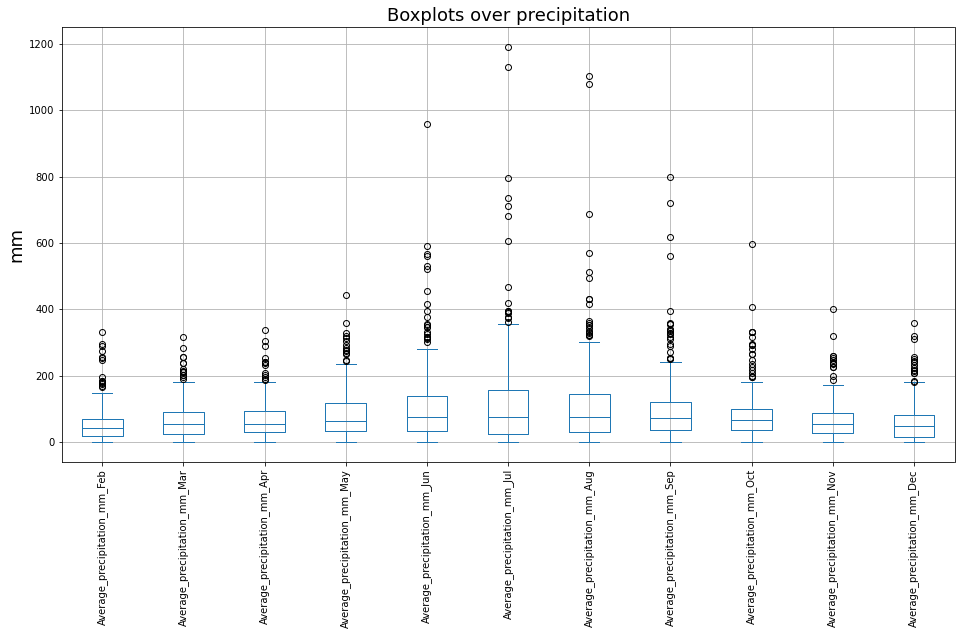

In [8]:
plt.figure(figsize = (16,8))
df_geomet.iloc[:,30:41].boxplot(color = "#1f77b4")
plt.title("Boxplots over precipitation", fontsize = 18)
plt.ylabel('mm', fontsize = 18)
plt.xticks(rotation = 90)
plt.show()

It can be seen that all distribution looks very skewed. A handfull of cities have much more precipitation than the general pattern seen in the dataset. A general trend is also that it rains more in the summer.

Let's move to the precipitation days:

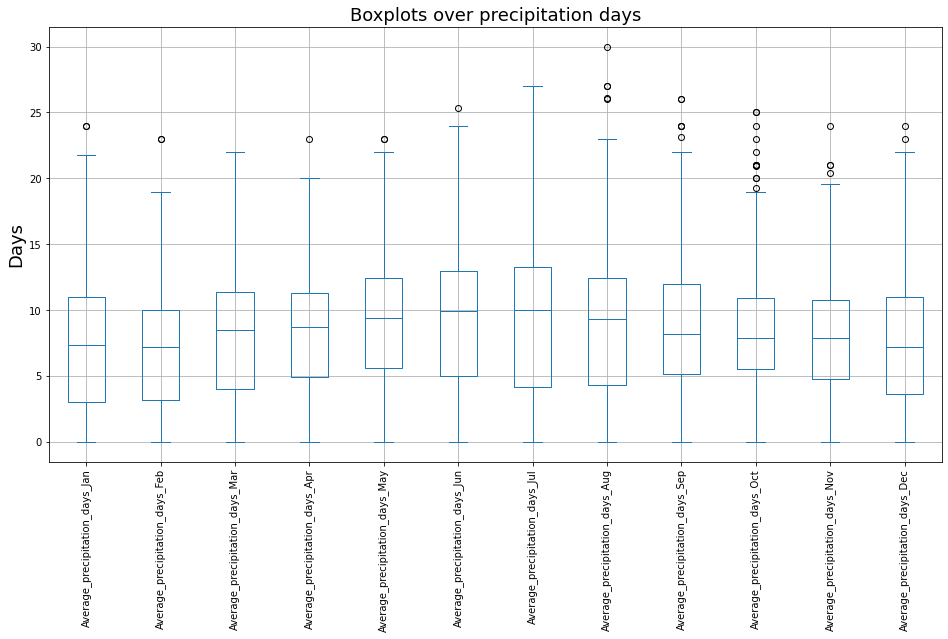

In [9]:
plt.figure(figsize = (16,8))
df_geomet.iloc[:,41:53].boxplot(color = "#1f77b4")
plt.title("Boxplots over precipitation days", fontsize = 18)
plt.ylabel('Days', fontsize = 18)
plt.xticks(rotation = 90)
plt.show()


Now the skewness has been limited compared to the plot over mm but again it looks slightly skewed towards many days.  THe highest values are again seen in the summer.

### Sunshine hours

Let's now look at the sunshine hours - again with the same type of boxplots:

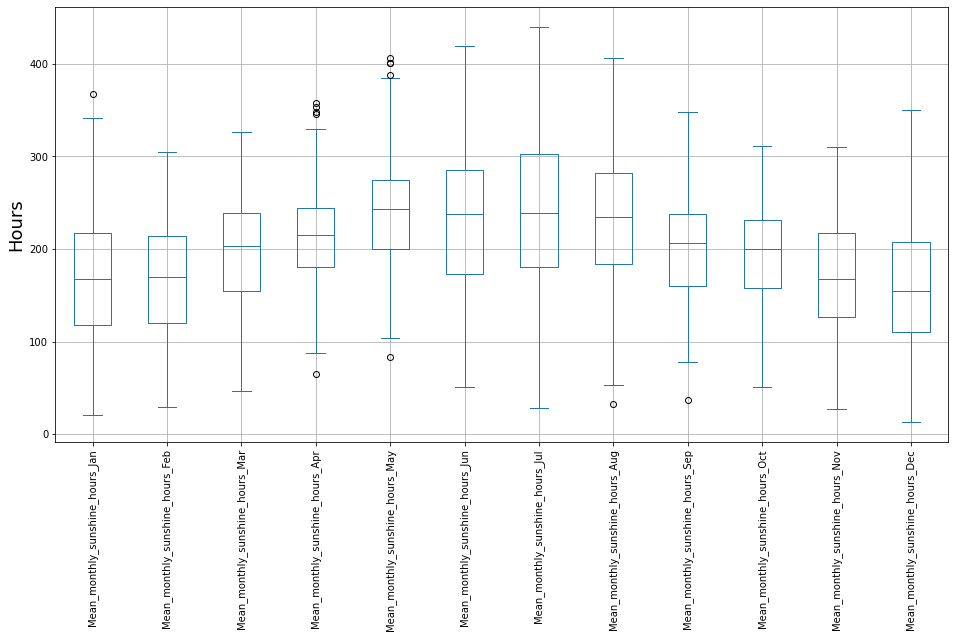

In [10]:
plt.figure(figsize = (16,8))
df_geomet.iloc[:,53:].boxplot(color = "#1f77b4")
plt.ylabel('Hours', fontsize = 18)
plt.xticks(rotation = 90)
plt.show()

It is seen that there is a curve across the year with more sunshine in the summer months on average. The variation is though also larger in the summer.

## Correlation analysis
Now we move onto investigating the intercorrelation as it was done with the original data. Again, due to the vast amount of variables a heatmap is used to illustrate the correlation. The plot is shown below:

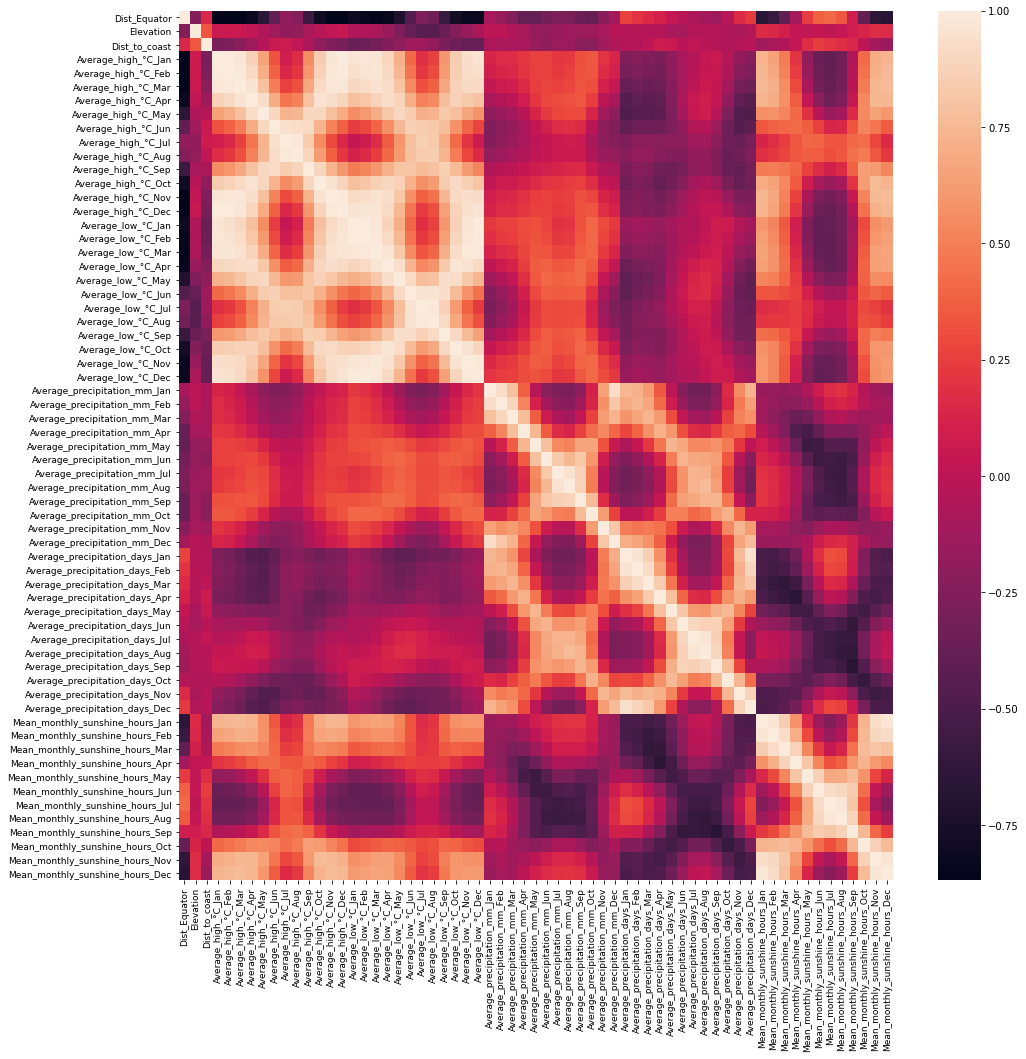

In [11]:
plt.figure(figsize = (16,16))
sns.heatmap(df_geomet.corr(),xticklabels=True, yticklabels=True)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.show()

Some interesting patterns are seen. It is quite easy to see that there are different *types* of variables in the sesse that correlation patterns are seen within the average high, average low, precipatation and sunshine across the 12 months of the year. This of course makes perfect sense as correlation between the different months are expected. It is also clear that months closer to eachother are more similar - again this is expected. Unsurprisingly a large negative correlation can also be seen between the sunshine hours and precipatation. Looking at the distance to equator some very negative correlations are seen with the temperature meaning that the closer to the equator you are the hotter it is - again a common fact now verified by the numbers.

Let's move on to investigating the correlation of the new variables with the $CO_2$ emission that is to be predeicted. This is also done completely analougly with the descriptive analysis of the orignal data.

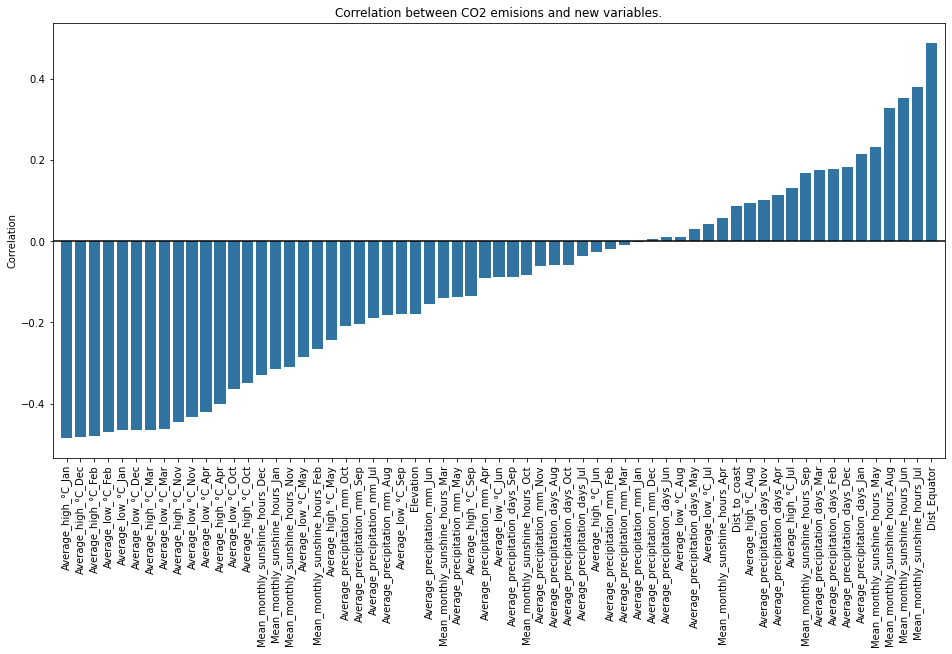

In [12]:
# Add Co2 emission to check for correlation
df_geomet['CO2_Emissions_per_Capita_(metric_tonnes)'] = df_orig.reset_index()['CO2_Emissions_per_Capita_(metric_tonnes)']
corr_list = df_geomet.corr().loc['CO2_Emissions_per_Capita_(metric_tonnes)'][df_geomet.corr().loc['CO2_Emissions_per_Capita_(metric_tonnes)'] <1]

# Make barplot
plt.figure(figsize = (16,8))
sns.barplot(corr_list.sort_values().index, corr_list.sort_values().values, color = "tab:blue")
plt.axhline(y=0, color = "k")
plt.title("Correlation between CO2 emisions and new variables.")
plt.xticks(rotation = 90)
plt.xlim([-1,len(corr_list)])
plt.ylabel("Correlation")
plt.show()

Here it is seen that we deffinitly have some interesting correlations. Lower temperatures in the winter clearly seems to lead to greater $CO_2$ emission. On the opposite side of the spectrum the emission also grows when cities gets further away from the equator.

### PCA

The correlation heat map clearly revealed high inter correlations between the variables. And that is not surprising as many of them are cluster togehter symbolising the same thing - just for different months. Therefor a PCA is carried out to get an idea of how large this effect is.

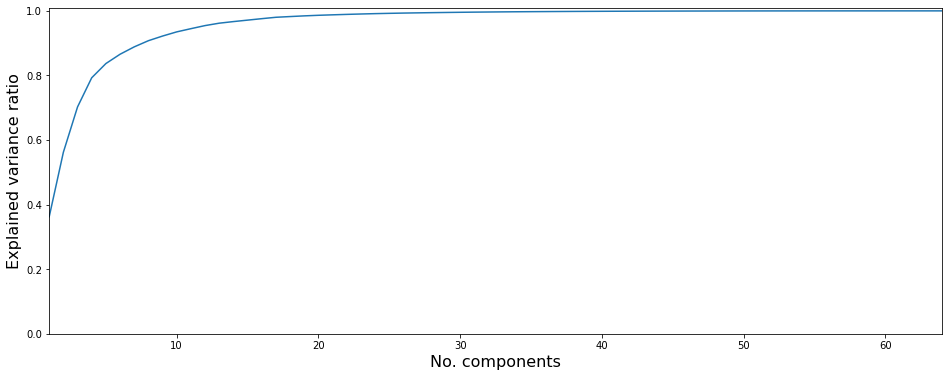



Using the 1 first principal components explains 36.250% of the variance
Using the 10 first principal components explains 93.497% of the variance
Using the 20 first principal components explains 98.631% of the variance
Using the 30 first principal components explains 99.559% of the variance


In [22]:
# Make pca and git
pca = PCA()
pca.fit(df_geomet.drop(columns = ["City", "Country"]).apply(lambda x: (x-x.mean())/x.std()))

# Calculate cummulitative explained variance ration
expl=pca.explained_variance_ratio_
cdf=[sum(expl[:i+1]) for i in range(len(expl))]

# Plot
plt.figure(figsize=(16,6))
plt.plot(range(1,1+len(expl)), cdf, color = '#1f77b4')
plt.xlabel("No. components", fontsize = 16)
plt.ylabel("Explained variance ratio", fontsize = 16)
plt.xlim(1,len(expl))
plt.ylim(0,1.01)
plt.show()

# Print results for some selected values
print('\n')
get_expl_var = [1,10,20,30]
for comp in get_expl_var:
    print(f'Using the {comp} first principal components explains {100*cdf[comp-1]:.3f}% of the variance')

Compared with the PCA over the original variables a higher correlation is seen in the geographical and meteorological data as more of the variance can be explained with fewer components. Now the first one accounts for 36% of the variance and with 30 (less than half of the total) we can explain more than 99.5% of the variation in the data. As discussed above it is though also expected. Once again we will rely on regularisation to accounts for this intercorrelation.

In [23]:
#dict(zip(df_geomet.columns,pca.components_[0]))